In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from wmfdata import hive, mariadb
from wmfdata.charting import comma_fmt, M_fmt, pct_fmt, set_mpl_style
from wmfdata.utils import pct_str

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [3]:
%matplotlib inline
set_mpl_style()

In [7]:
m = pd.read_csv(
    "../metrics/metrics.tsv", 
    sep="\t",
    parse_dates=["month"]
).set_index("month")

# Latest Hive snapshot
SNAPSHOT = "2019-01"
START = "2015-02"

def wiki_segment(w):
    next_10_wps = (
        "eswiki", "dewiki", "jawiki", "frwiki", "ruwiki",
        "itwiki", "zhwiki", "ptwiki", "plwiki", "nlwiki"
    )
    
    if w == "enwiki":
        return "English Wikipedia"
    elif w in next_10_wps:
        return "'next 10' Wikipedias"
    elif w == "commonswiki":
        return "Commons"
    elif w == "wikidatawiki":
        return "Wikidata"
    else:
        return "other projects"

# Edits and revert rates by segment

In [43]:
%%time
wiki_reverts_r = hive.run("""
select 
    wiki_db,
    date_format(event_timestamp, "YYYY-MM") as month,
    count(*) as edits,
    sum(cast(revision_is_identity_reverted as int)) as reverted_edits
from wmf.mediawiki_history
where
    event_entity = "revision" and
    event_type = "create" and
    event_timestamp >= "{start}" and
    -- Fix for bogus data for 2019-12
    event_timestamp < "2019-02" and
    snapshot = "{snapshot}"
group by wiki_db, date_format(event_timestamp, "YYYY-MM")
""".format(
    start=START, 
    snapshot=SNAPSHOT
))

CPU times: user 972 ms, sys: 0 ns, total: 972 ms
Wall time: 1min 25s


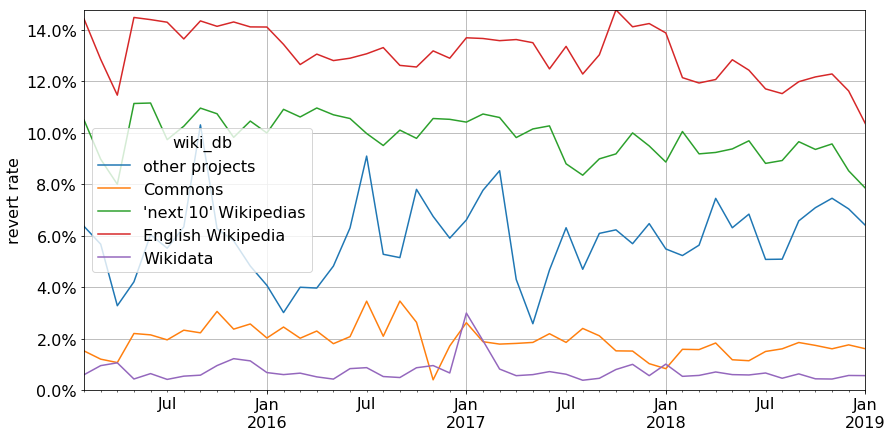

In [47]:
wiki_reverts = (
    wiki_reverts_r
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
    .pivot(columns="wiki_db")
    .fillna(0)
    .rename(columns=wiki_segment, level=1)
    .sum(axis=1, level=[0, 1])
)[:"2019-01"]

segment_revert_rates = wiki_reverts["reverted_edits"] / wiki_reverts["edits"]
ax = segment_revert_rates.plot(ylim=0)
ax.yaxis.set_major_formatter(pct_fmt)
plt.xlabel("")
plt.ylabel("revert rate");

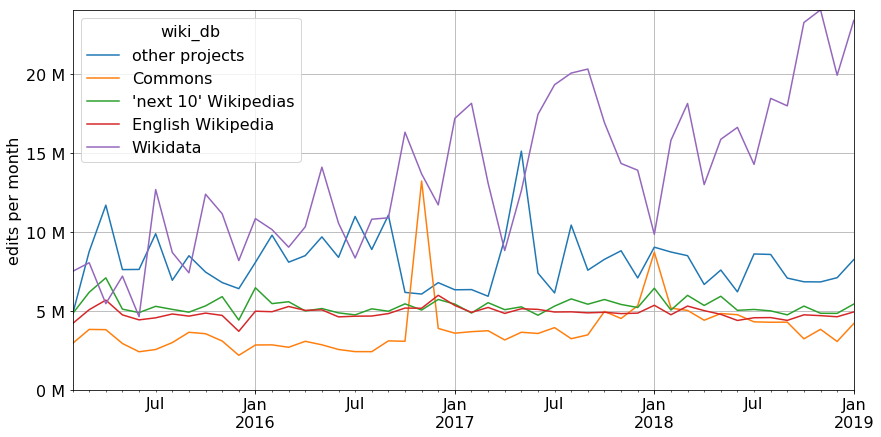

In [52]:
ax = wiki_reverts["edits"].plot(ylim=0)
ax.yaxis.set_major_formatter(M_fmt)
plt.xlabel("")
plt.ylabel("edits per month");

# Edits by platform

In [8]:
platform_edits = m[
        ["nonbot_nondata_nonupload_edits", "mobile_edits"]
    ].rename({
        "nonbot_nondata_nonupload_edits": "total_edits"
    }, axis=1)

In [12]:
platform_edits["desktop_edits"] = platform_edits["total_edits"] - platform_edits["mobile_edits"]

In [28]:
plt_pct = pd.DataFrame()
plt_pct["mobile edits"] = platform_edits["mobile_edits"] / platform_edits["total_edits"]
plt_pct["desktop edits"] = platform_edits["desktop_edits"] / platform_edits["total_edits"]

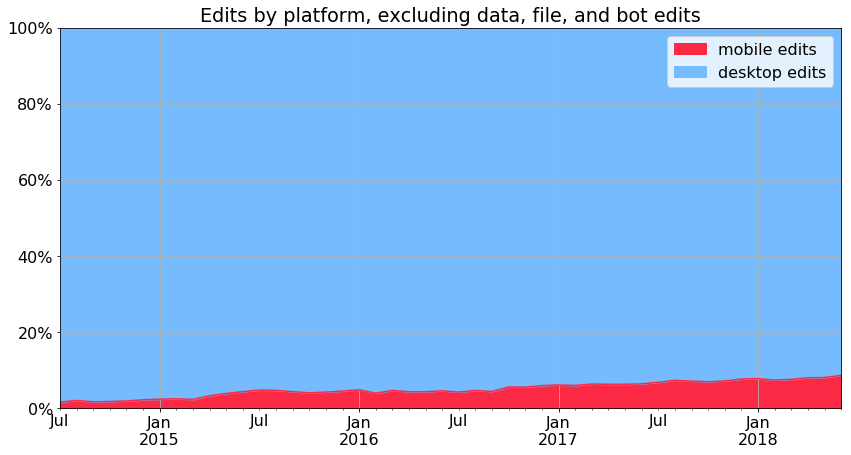

In [78]:
plt_pct["2014-07":].plot.area(
    ylim=(0,1), 
    title="Edits by platform, excluding data, file, and bot edits",
    colormap=mpl.colors.ListedColormap(["xkcd:strawberry", "xkcd:sky blue"])
)
ax = plt.gca()
plt.xlabel("")
ax.yaxis.set_major_formatter(pct_fmt)
plt.autoscale(enable=True, axis="x", tight=True);

In [23]:
nonbot_wd_edits = wmf.hive.run("""
select
    date_format(event_timestamp, "yyyy-MM-01") as month,
    count(*) as nonbot_wd_edits
from wmf.mediawiki_history
where
    wiki_db = "wikidatawiki" and
    event_user_is_bot_by_name = false and
    not array_contains(event_user_groups, "bot") and
    event_entity = "revision" and
    event_type = "create" and
    event_timestamp >= "2017-11" and
    snapshot = "{snapshot}"
group by date_format(event_timestamp, "yyyy-MM-01")
""".format(snapshot=SNAPSHOT))

nonbot_wd_edits = nonbot_wd_edits.set_index("month")
nonbot_wd_edits.index = pd.to_datetime(nonbot_wd_edits.index)

month
2017-12-01    5526878
2018-02-01    5400587
2018-04-01    5415228
2017-11-01    6453015
2018-01-01    4586332
2018-03-01    8586762
Name: nonbot_wd_edits, dtype: int64

In [34]:
avg_nonbot_edits = m.loc["2017-11":, "nonbot_edits"].mean()
avg_mobile_edits = m.loc["2017-11":, ["mobile_web_edits", "mobile_app_edits"]].sum(axis=1).mean()
avg_nonbot_wd_edits = nonbot_wd_edits.loc[:, "nonbot_wd_edits"].mean()

print(avg_nonbot_edits, avg_mobile_edits, avg_nonbot_wd_edits)

21546183.666666668 1067129.0 5994800.333333333


In [28]:
nonbot_wd_edits

,nonbot_wd_edits
month,
2017-12-01,5526878
2018-02-01,5400587
2018-04-01,5415228
2017-11-01,6453015
2018-01-01,4586332
2018-03-01,8586762


# Non-bot edits exploration

In [185]:
edits = m["nonbot_edits"]
edits.tail()

month
2017-12-01    19926673.0
2018-01-01    20374752.0
2018-02-01    19934503.0
2018-03-01    25176956.0
2018-04-01    20762284.0
Name: nonbot_edits, dtype: float64

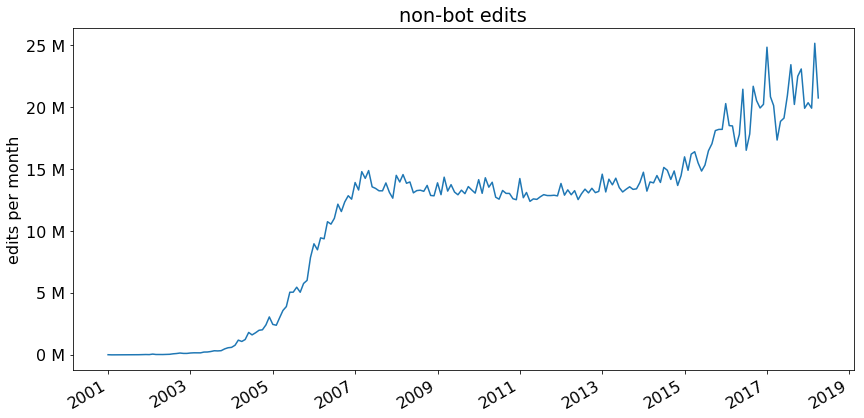

In [186]:
edits.plot()
plt.xlabel("")
ax = plt.gca()
plt.title("non-bot edits")
ax.yaxis.set_major_formatter(M_fmt)
plt.ylabel("edits per month");

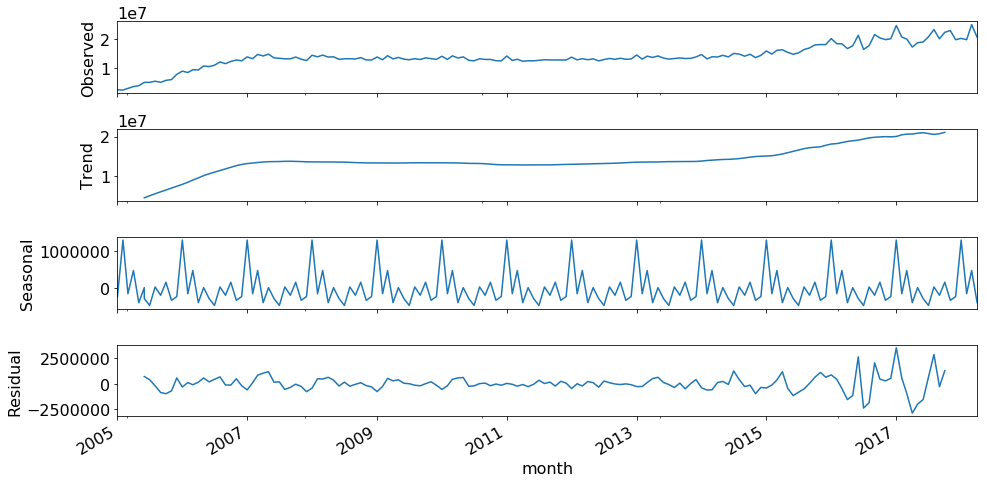

In [187]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(edits["2005-01":], model='additive', freq=12)
result.plot()
plt.autoscale(enable=True, axis="x", tight=True)

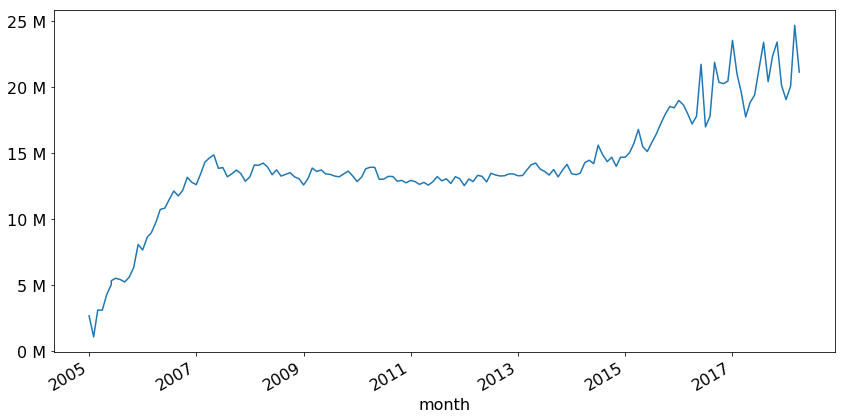

In [190]:
(result.observed - result.seasonal).plot()
ax = plt.gca()
ax.yaxis.set_major_formatter(M_fmt);

# Daily revisions by wiki

In [122]:
# `dr` stands for "daily revisions"
dr_raw = wmf.hive.run("""
    select
        wiki_db as wiki,
        dt as d,
        sum(if(metric = "daily_edits", value, 0)) - sum(if(metric = "daily_edits_by_bot_users", value, 0)) as nonbot_revs
    from wmf.mediawiki_metrics
    where
        snapshot = "2018-04" and
        metric in ("daily_edits", "daily_edits_by_bot_users")
    group by wiki_db, dt
""")

In [137]:
dr = dr_raw.pivot(index="d", columns="wiki").fillna(0)
dr.columns = dr.columns.droplevel(0)
dr.index = pd.to_datetime(dr.index)
dr.tail()

wiki,abwiki,acewiki,adywiki,afwiki,afwikibooks,afwikiquote,afwiktionary,akwiki,alswiki,amwiki,...,zh_yuewiki,zhwiki,zhwikibooks,zhwikinews,zhwikiquote,zhwikisource,zhwikivoyage,zhwiktionary,zuwiki,zuwiktionary
d,,,,,,,,,,,,,,,,,,,,,
2018-03-27,51.0,2.0,1.0,110.0,0.0,0.0,43.0,4.0,345.0,25.0,...,246.0,14146.0,9.0,4.0,157.0,188.0,53.0,78.0,10.0,0.0
2018-03-28,44.0,4.0,1.0,144.0,0.0,1.0,0.0,3.0,111.0,11.0,...,272.0,11326.0,23.0,4.0,116.0,183.0,29.0,22.0,8.0,1.0
2018-03-29,28.0,11.0,1.0,168.0,0.0,0.0,0.0,3.0,82.0,5.0,...,249.0,12072.0,12.0,18.0,4.0,237.0,41.0,34.0,2.0,0.0
2018-03-30,26.0,0.0,2.0,139.0,0.0,2.0,80.0,3.0,72.0,26.0,...,337.0,11026.0,18.0,4.0,43.0,262.0,21.0,116.0,1231.0,0.0
2018-03-31,230.0,3.0,0.0,144.0,0.0,4.0,0.0,3.0,50.0,27.0,...,229.0,12137.0,27.0,1.0,19.0,417.0,38.0,356.0,8.0,0.0


In [162]:
# Which are our most-edited wikis, on average?
dr["2018":].mean().sort_values(ascending=False).head(20)

wiki
wikidatawiki    206936.900000
enwiki          145853.777778
commonswiki      99259.266667
dewiki           29074.822222
frwiki           25188.788889
viwiki           25152.800000
eswiki           18992.711111
ruwiki           16716.244444
itwiki           14462.766667
jawiki           12025.555556
zhwiki           11969.700000
ptwiki            8257.044444
plwiki            6562.622222
ukwiki            6214.500000
nlwiki            5776.111111
kowiki            5510.922222
hewiki            4828.133333
enwiktionary      4471.322222
fawiki            4163.655556
arwiki            4048.244444
dtype: float64

A big spike among other projects in August 2017 seems to be in the Vietnamese Wikipedia.

In [164]:
dr["2017-08-01":"2017-08-31"].mean().sort_values(ascending=False).head(20)

wiki
wikidatawiki    180667.838710
enwiki          135632.774194
viwiki          126688.322581
commonswiki      87133.354839
dewiki           24562.935484
frwiki           22066.419355
eswiki           17683.290323
ruwiki           15456.387097
itwiki           13174.419355
zhwiki           11655.677419
jawiki           11136.225806
ptwiki            8519.483871
plwiki            5726.129032
hewiki            5449.258065
nlwiki            4976.387097
kowiki            4945.225806
ukwiki            4819.419355
enwiktionary      4444.838710
arwiki            3995.032258
fawiki            3879.838710
dtype: float64

In [168]:
def segment(wiki):
    if wiki == "enwiki":
        return "English Wikipedia"
    elif wiki == "commonswiki":
        return "Commons"
    elif wiki == "wikidatawiki":
        return "Wikidata"
    elif wiki == "viwiki":
        return "Vietnamese Wikipedia"
    else:
        return "Other projects"

dr_seg = dr.groupby(segment, axis = 1).sum()

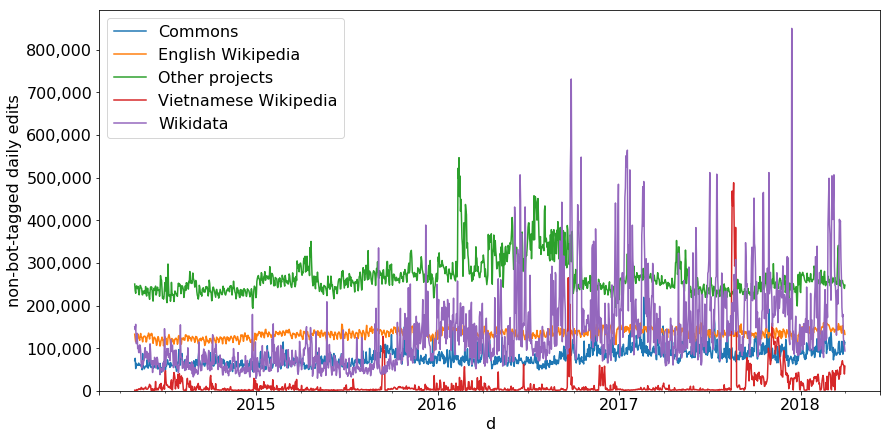

In [169]:
dr_seg["2014-05":].plot(ylim=0)
ax = plt.gca()
ax.yaxis.set_major_formatter(comma_fmt)
plt.ylabel("non-bot-tagged daily edits");

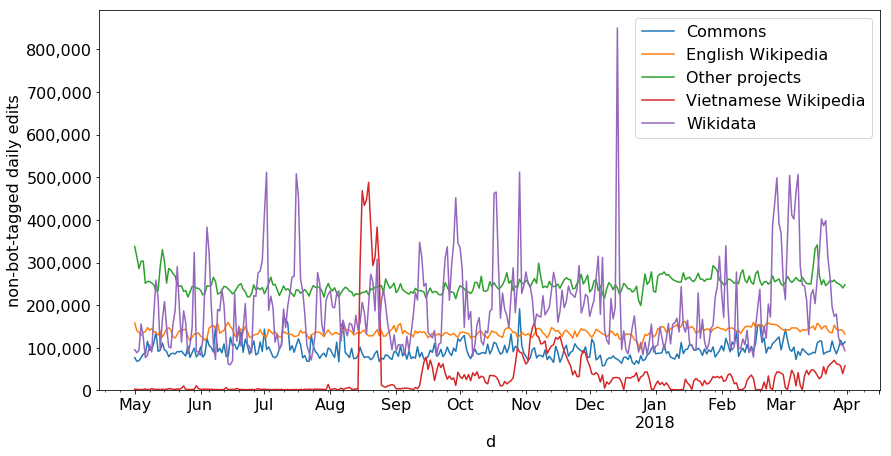

In [170]:
dr_seg["2017-05":].plot(ylim=0)
ax = plt.gca()
ax.yaxis.set_major_formatter(comma_fmt)
plt.ylabel("non-bot-tagged daily edits");